Финальный проект - ВАРИАНТ 2

In [1]:
import pandas as pd
from operator import attrgetter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro, levene, kstest, norm, anderson # Импортируем kstest для K-S теста (одновыборочный) и anderson для Андерсона-Дарлинга


In [2]:
groups_a_b = pd.read_csv('Проект_2_groups.csv', sep=';')

In [3]:
groups_a_b_add = pd.read_csv('Проект_2_group_add.csv', sep=',')

In [4]:
active_studs = pd.read_csv('Проект_2_active_studs.csv', sep=';')

In [5]:
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

!!!Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [6]:
groups_a_b

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [7]:
groups_a_b_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [8]:
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [9]:
checks 

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [10]:
# Объединяем информацию о группах
# Сначала объединяем groups.csv и groups_add.csv
all_groups = pd.concat([groups_a_b, groups_a_b_add], ignore_index=True)

In [11]:
# Переименовываем колонку 'id' в 'student_id' для удобства объединения
all_groups = all_groups.rename(columns={'id': 'student_id'})

In [12]:
# Объединяем данные об активных студентах с информацией о группах
#left merge, чтобы сохранить всех студентов из all_groups
all_groups_merged = pd.merge(all_groups, active_studs, on='student_id', how='left', indicator=True)

In [13]:
#Добавляем информацию об активности. Если студент не в active_studs, is_active будет 0.
all_groups_merged['is_active'] =all_groups_merged['_merge'].apply(lambda x: 1 if x == 'both' else 0)
all_groups_merged = all_groups_merged.drop(columns=['_merge'])

In [14]:
all_groups_merged

,student_id,grp,is_active
0,1489,B,0
1,1627,A,1
2,1768,B,0
3,1783,B,0
4,1794,A,0
...,...,...,...
74571,200247820,B,0
74572,201032527,B,0
74573,201067612,B,0
74574,201067653,B,0


In [15]:
# Объединяем с данными о чеках. Используем left merge.
all_groups_merged = pd.merge(all_groups_merged, checks, on='student_id', how='left')


In [16]:
# Заполняем NaN в 'rev' нулями для тех, кто не совершал покупки
all_groups_merged['rev'] =all_groups_merged['rev'].fillna(0)

In [17]:
# Добавляем колонку 'is_paid', которая будет 1- соверш покупку, 0 - не совершал
all_groups_merged['is_paid'] = all_groups_merged['rev'].apply(lambda x: 1 if x > 0 else 0)


In [18]:
# Проверяем студентов, которые попали в обе группы
students_AB_groups = all_groups_merged.groupby('student_id')['grp'].nunique()

In [19]:
students_AB_groups.reset_index().query('grp > 1') #cтуденты не попали в несколько групп.

,student_id,grp


In [20]:
# Проверяем на баги, например есть пользователи, которые оплатили, но при этом не активные
paying_but_inactive_students = all_groups_merged[(all_groups_merged['is_paid'] == 1) & (all_groups_merged['is_active'] == 0)]

In [21]:
paying_but_inactive_students #149 студентов оплатили но не были активными (нужно разобраться почему так!!!)

,student_id,grp,is_active,rev,is_paid
39,3185,B,0,690.0,1
121,25973,B,0,690.0,1
125,26280,B,0,690.0,1
223,100645,B,0,630.0,1
254,102534,B,0,580.0,1
...,...,...,...,...,...
72452,5291900,B,0,199.0,1
72753,5331842,B,0,290.0,1
73632,5486319,B,0,199.0,1
74049,5562806,B,0,398.0,1


In [22]:
#По умолчанию, для целей анализа A/B-теста, такие пользователи будут считаться активными.
all_groups_merged.loc[paying_but_inactive_students.index, 'is_active'] = 1

In [23]:
#Рассмотрим как распределены активные и платящие пользователи по группам! !18:82
all_groups_merged[(all_groups_merged['is_active'] == 1) & (~all_groups_merged.rev.isna())]['grp'] \
    .value_counts(normalize=True).mul(100).round()

B    82.0
A    18.0
Name: grp, dtype: float64

In [24]:
# Разделяем данные на контрольную и целевую группы
group_a = all_groups_merged[all_groups_merged['grp'] == 'A']
group_b = all_groups_merged[all_groups_merged['grp'] == 'B']

In [25]:
all_groups_merged

,student_id,grp,is_active,rev,is_paid
0,1489,B,0,0.0,0
1,1627,A,1,990.0,1
2,1768,B,0,0.0,0
3,1783,B,0,0.0,0
4,1794,A,0,0.0,0
...,...,...,...,...,...
74571,200247820,B,0,0.0,0
74572,201032527,B,0,0.0,0
74573,201067612,B,0,0.0,0
74574,201067653,B,0,0.0,0


In [26]:
group_a

,student_id,grp,is_active,rev,is_paid
1,1627,A,1,990.0,1
4,1794,A,0,0.0,0
7,2067,A,0,0.0,0
8,2078,A,0,0.0,0
11,2213,A,0,0.0,0
...,...,...,...,...,...
74558,5870856,A,1,0.0,0
74560,5921522,A,0,0.0,0
74567,200247808,A,0,0.0,0
74568,200247809,A,0,0.0,0


In [27]:
group_b

,student_id,grp,is_active,rev,is_paid
0,1489,B,0,0.0,0
2,1768,B,0,0.0,0
3,1783,B,0,0.0,0
5,1803,B,0,0.0,0
6,1805,B,0,0.0,0
...,...,...,...,...,...
74571,200247820,B,0,0.0,0
74572,201032527,B,0,0.0,0
74573,201067612,B,0,0.0,0
74574,201067653,B,0,0.0,0



 Проверка нормальности для  доходов платящих пользователей в Группе A 


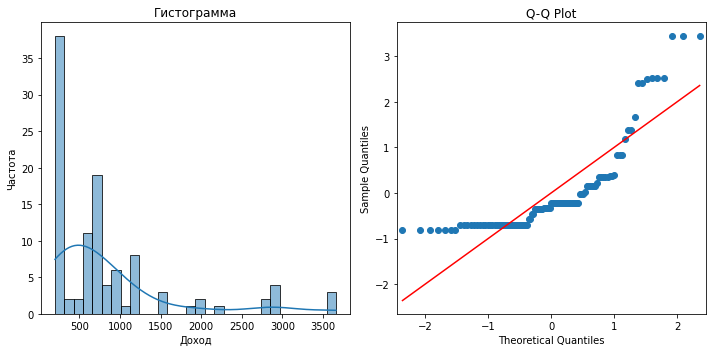


 Проверка нормальности для доходов платящих пользователей в Группе B 


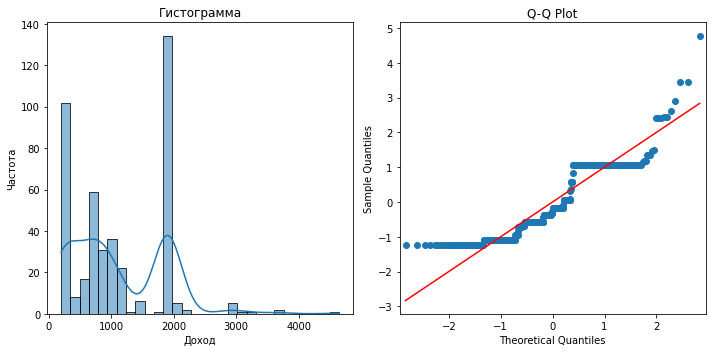


 Проверка нормальности для доходов всех активных пользователей в Группе A 


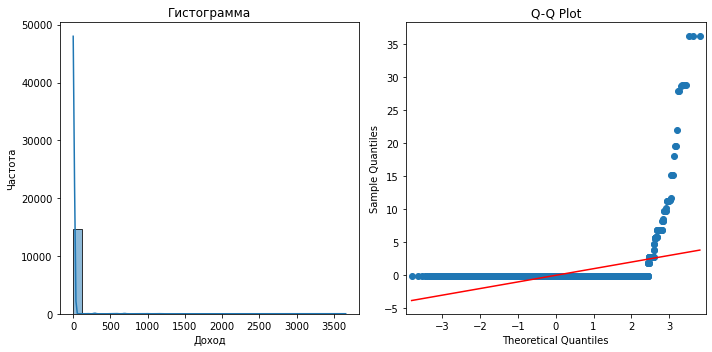


 Проверка нормальности для доходов всех активных пользователей в Группе B 


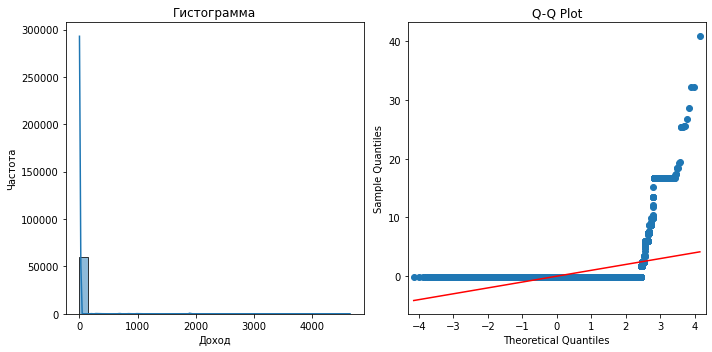

In [43]:
# Подготовка данных для тестов (доходы платящих и всех активных)
revenue_a_paying = group_a[group_a['is_paid'] == 1]['rev'].values
revenue_b_paying = group_b[group_b['is_paid'] == 1]['rev'].values
revenue_a_all = group_a['rev'].values
revenue_b_all = group_b['rev'].values

alpha = 0.05 # Уровень значимости
# Проверка нормальности распределения (Визуализация) 

def run_normality_test(data, group_name, data_type):
    print(f"\n Проверка нормальности для {data_type} в {group_name} ")
    if len(data) < 3:
        print("Недостаточно данных (менее 3 наблюдений) для проведения проверки нормальности распределения.")
        return
 #Используем визуальную оценку (гистограмма, Q-Q Plot), так как обьем данных слишком большой
    # Визуальная оценка: Гистограмма
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, bins=30)
    plt.title(f'Гистограмма')
    plt.xlabel('Доход')
    plt.ylabel('Частота')

    # Визуальная оценка: Q-Q Plot
    plt.subplot(1, 2, 2)
    sm.qqplot(data, line='s', fit=True, ax=plt.gca())
    plt.title(f'Q-Q Plot')
    plt.tight_layout()
    plt.show()


# Проверяем нормальность для доходов платящих пользователей
if len(revenue_a_paying) > 0:
    run_normality_test(revenue_a_paying, "Группе A", " доходов платящих пользователей")
if len(revenue_b_paying) > 0:
    run_normality_test(revenue_b_paying, "Группе B", "доходов платящих пользователей")

# Проверяем нормальность для доходов всех активных пользователей (включая нули)
# Ожидаем, что эти распределения НЕ будут нормальными из-за большого количества нулей
if len(revenue_a_all) > 0:
    run_normality_test(revenue_a_all, "Группе A", "доходов всех активных пользователей")
if len(revenue_b_all) > 0:
    run_normality_test(revenue_b_all, "Группе B", "доходов всех активных пользователей")


Общий вывод по всем четырем графикам (Группа A и Группа B):
Все четыре представленных распределения дохода (как для платящих пользователей, так и для всех активных пользователей, в обеих группах) не являются нормальными. Они характеризуются сильной правосторонней скошенностью, а распределения "всех активных пользователей" дополнительно имеют массивный пик на нуле из-за неплатящих клиентов.

Было бы верно для статистического анализа выбрать Z-тест для конверсии и Бутстрап для ARPU/ARPPU, так как эти методы не полагаются на предположение о нормальности распределения данных.

In [44]:
# Проверка равенства дисперсий (Тест Левена) 
print("\n Проверка равенства дисперсий (Тест Левена) ")

# Проверяем равенство дисперсий для доходов платящих пользователей
print("\Тест Левена для доходов платящих пользователей (ARPPU)")
# H0: Дисперсии доходов платящих пользователей в Группе A и Группе B равны.
# H1: Дисперсии доходов платящих пользователей в Группе A и Группе B не равны.
if len(revenue_a_paying) > 1 and len(revenue_b_paying) > 1:
    stat_levene_paying, p_value_levene_paying = levene(revenue_a_paying, revenue_b_paying)
   
    print(f"  Статистика = {stat_levene_paying:.4f}")
    print(f"  P-значение = {p_value_levene_paying:.4f}")

    if p_value_levene_paying < alpha:
        print(f"  P-значение ({p_value_levene_paying:.4f}) < alpha ({alpha}) - Отвергаем H0. Дисперсии статистически значимо различаются.")
    else:
        print(f"  P-значение ({p_value_levene_paying:.4f}) >= alpha ({alpha}) - Не отвергаем H0. Дисперсии не имеют статистически значимых различий.")

# Проверяем равенство дисперсий для доходов всех активных пользователей
print("\n Тест Левена для доходов всех активных пользователей (ARPU)")
# H0: Дисперсии доходов всех активных пользователей в Группе A и Группе B равны.
# H1: Дисперсии доходов всех активных пользователей в Группе A и Группе B не равны.
if len(revenue_a_all) > 1 and len(revenue_b_all) > 1:
    stat_levene_all, p_value_levene_all = levene(revenue_a_all, revenue_b_all)
    
    print(f"  Статистика = {stat_levene_all:.4f}")
    print(f"  P-значение = {p_value_levene_all:.4f}")

    if p_value_levene_all < alpha:
        print(f"  P-значение ({p_value_levene_all:.4f}) < alpha ({alpha}). - Отвергаем H0. Дисперсии **статистически значимо различаются.")
    else:
        print(f"  P-значение ({p_value_levene_all:.4f}) >= alpha ({alpha}). - Не отвергаем H0. Дисперсии не имеют статистически значимых различий.")



 Проверка равенства дисперсий (Тест Левена) 
\Тест Левена для доходов платящих пользователей (ARPPU)
  Статистика = 4.4789
  P-значение = 0.0348
  P-значение (0.0348) < alpha (0.05) - Отвергаем H0. Дисперсии статистически значимо различаются.

 Тест Левена для доходов всех активных пользователей (ARPU)
  Статистика = 2.9988
  P-значение = 0.0833
  P-значение (0.0833) >= alpha (0.05). - Не отвергаем H0. Дисперсии не имеют статистически значимых различий.


Выводы по проверке равенства дисперсий (Тест Левена):
Для доходов платящих пользователей (ARPPU):

P-значение теста Левена = 0.0348. Это меньше α=0.05.

Вывод: Мы отвергаем нулевую гипотезу. Дисперсии доходов платящих пользователей в Группе A и Группе B статистически значимо различаются. Это означает, что разброс сумм, которые тратят платящие пользователи, неодинаков в контрольной и тестовой группах (то есть, присутствует гетероскедастичность).

Для доходов всех активных пользователей (ARPU):

P-значение теста Левена = 0.0833. Это больше α=0.05.

Вывод: Мы не можем отвергнуть нулевую гипотезу. Дисперсии доходов всех активных пользователей в Группе A и Группе B не имеют статистически значимых различий. Это говорит о том, что общий разброс доходов (включая нули) в обеих группах схож.


Подтверждение выбора методов: Результаты проверок нормальности и равенства дисперсий ещё раз подтверждают, что использование Z-тест для конверсии и бутстрапа для сравнения ARPU и ARPPU будет правильным решением. Бутстрап не чувствителен к ненормальности распределений и к неравенству дисперсий, что делает его надёжным инструментом в данном случае.


В ходе анализа мы сфокусировались на трёх ключевых метриках, каждая из которых даёт уникальный взгляд на монетизацию:

 1. Конверсия (CR): Это доля пользователей, совершивших оплату. Мы смотрим на CR, чтобы понять, как механика влияет на количество платящих пользователей. Снижение CR может указывать на то, что новая механика усложнила процесс покупки или отпугнула часть потенциальных клиентов.

In [45]:
active_group_a = group_a[group_a['is_active'] == 1]
active_group_b = group_b[group_b['is_active'] == 1]

In [46]:
cr_a = active_group_a['is_paid'].mean()
cr_b = active_group_b['is_paid'].mean()

In [47]:
cr_a, cr_b

(0.06828334396936822, 0.06268958543983821)

In [48]:
z_paid_a = active_group_a['is_paid'].sum()
z_total_a = active_group_a.shape[0]
z_paid_b = active_group_b['is_paid'].sum()
z_total_b = active_group_b.shape[0]

In [49]:
#H0: Конверсия в группе A равна конверсии в группе B (cr_a = cr_b)
#H1: Конверсия в группе A не равна конверсии в группе B (cr_a != cr_b)

In [50]:
if z_total_a > 0 and z_total_b > 0:
    z_stat_cr, p_value_cr = proportions_ztest([z_paid_a, z_paid_b], [z_total_a, z_total_b])
    print(f"CR_A: {cr_a:.4f} ({z_paid_a}/{z_total_a}), CR_B: {cr_b:.4f} ({z_paid_b}/{z_total_b})")
    print(f"Z-статистика: {z_stat_cr:.3f}, P-value: {p_value_cr:.4f}")
    if p_value_cr < 0.05:
        print(f"Разница в CR СТАТИСТИЧЕСКИ ЗНАЧИМА (p < {0.05}). Отвергаем H0.")
    else:
        print(f"Разница в CR СТАТИСТИЧЕСКИ НЕЗНАЧИМА (p >= {0.05}). Не можем отвергнуть H0.")

CR_A: 0.0683 (107/1567), CR_B: 0.0627 (434/6923)
Z-статистика: 0.819, P-value: 0.4130
Разница в CR СТАТИСТИЧЕСКИ НЕЗНАЧИМА (p >= 0.05). Не можем отвергнуть H0.


 2. Средний чек платящих пользователей (ARPPU): Это средний доход с платящего пользователя. ARPPU позволяет оценить, как механика влияет на объём трат тех, кто уже решил платить. Его рост может означать, что пользователи стали покупать более дорогие товары/услуги или совершать больше повторных покупок.

In [51]:
paying_group_a_arppu = group_a[group_a['is_paid'] == 1]['rev']
paying_group_b_arppu = group_b[group_b['is_paid'] == 1]['rev']

In [52]:
arppu_a = paying_group_a_arppu.mean() 
arppu_b = paying_group_b_arppu.mean() 

In [53]:
#H0: Средний чек платящих в группе A равен среднему чеку платящих в группе B (ARPPU_A = ARPPU_B)
#H1: Средний чек платящих в группе A не равен среднему чеку платящих в группе B (ARPPU_A != ARPPU_B)

In [54]:
n_bootstraps = 10000
alpha = 0.05
diffs_arppu = []
for _ in range(n_bootstraps):
    sample_a = np.random.choice(paying_group_a_arppu, len(paying_group_a_arppu), replace=True)
    sample_b = np.random.choice(paying_group_b_arppu, len(paying_group_b_arppu), replace=True)
    diffs_arppu.append(np.mean(sample_b) - np.mean(sample_a))

ci_lower_arppu = np.percentile(diffs_arppu, (alpha/2) * 100)
ci_upper_arppu = np.percentile(diffs_arppu, (1 - alpha/2) * 100)
    
p_value_arppu = (
            (np.sum(np.array(diffs_arppu) <= 0) / n_bootstraps if np.mean(diffs_arppu) > 0 else
             np.sum(np.array(diffs_arppu) >= 0) / n_bootstraps) * 2
        )
if p_value_arppu > 1.0: p_value_arppu = 1.0

print(f"ARPPU_A: {arppu_a:.2f}, ARPPU_B: {arppu_b:.2f}")
print(f"Бутстрап разница B-A: {np.mean(diffs_arppu):.2f}, 95% CI: [{ci_lower_arppu:.2f}, {ci_upper_arppu:.2f}]")
print(f"Приблизительный P-value: {p_value_arppu:.4f}")
if (ci_lower_arppu > 0) or (ci_upper_arppu < 0):
    print(f"Разница в ARPPU СТАТИСТИЧЕСКИ ЗНАЧИМА (CI не содержит 0). Отвергаем H0.")
else:
    print(f"Разница в ARPPU СТАТИЧЕСКИ НЕЗНАЧИМА (CI содержит 0). Не можем отвергнуть H0.")


ARPPU_A: 860.71, ARPPU_B: 1108.82
Бутстрап разница B-A: 247.09, 95% CI: [71.56, 410.29]
Приблизительный P-value: 0.0076
Разница в ARPPU СТАТИСТИЧЕСКИ ЗНАЧИМА (CI не содержит 0). Отвергаем H0.


3. Средний доход на пользователя (ARPU): Это средний доход со всех активных пользователей, включая тех, кто не платит. ARPU является ключевой сквозной метрикой монетизации, так как она агрегирует влияние как на конверсию, так и на средний чек. Именно ARPU наиболее полно отражает общий финансовый эффект от изменения, и именно на эту метрику чаще всего ориентируются при принятии бизнес-решений о масштабировании.

In [55]:
arpu_a = group_a['rev'].mean()
arpu_b = group_b['rev'].mean()

In [56]:
#H0: Средний доход на пользователя в группе A равен среднему доходу в группе B (ARPU_A = ARPU_B)
#H1: Средний доход на пользователя в группе A не равен среднему доходу в группе B (ARPU_A != ARPU_B)

In [57]:
n_bootstraps = 10000
alpha = 0.05
diffs_arpu = []
for _ in range(n_bootstraps):
    sample_a = np.random.choice(group_a['rev'], len(group_a['rev']), replace=True)
    sample_b = np.random.choice(group_b['rev'], len(group_b['rev']), replace=True)
    diffs_arpu.append(np.mean(sample_b) - np.mean(sample_a))

ci_lower_arpu = np.percentile(diffs_arpu, (alpha/2) * 100)
ci_upper_arpu = np.percentile(diffs_arpu, (1 - alpha/2) * 100)
    
p_value_arpu = (
            (np.sum(np.array(diffs_arpu) <= 0) / n_bootstraps if np.mean(diffs_arpu) > 0 else
             np.sum(np.array(diffs_arpu) >= 0) / n_bootstraps) * 2
        )
if p_value_arpu > 1.0: p_value_arpu = 1.0

print(f"ARPU_A: {arpu_a:.2f}, ARPU_B: {arpu_b:.2f}")
print(f"Бутстрап разница B-A: {np.mean(diffs_arpu):.2f}, 95% CI: [{ci_lower_arpu:.2f}, {ci_upper_arpu:.2f}]")
print(f"Приблизительный P-value: {p_value_arpu:.4f}")
if (ci_lower_arpu > 0) or (ci_upper_arpu < 0):
    print(f"Разница в ARPU СТАТИСТИЧЕСКИ ЗНАЧИМА (CI не содержит 0). Отвергаем H0.")
else:
    print(f"Разница в ARPU СТАТИЧЕСКИ НЕЗНАЧИМА (CI содержит 0). Не можем отвергнуть H0.")


ARPU_A: 6.27, ARPU_B: 8.04
Бутстрап разница B-A: 1.76, 95% CI: [-0.20, 3.58]
Приблизительный P-value: 0.0764
Разница в ARPU СТАТИЧЕСКИ НЕЗНАЧИМА (CI содержит 0). Не можем отвергнуть H0.


Комплексный вывод по A/B-тесту и критической проблеме с качеством данных.
Проведённый анализ A/B-теста новой механики выявил неоднозначные результаты по ключевым метрикам и, что крайне важно, обнаружил существенную проблему с качеством данных.

1. Результаты A/B-теста: Частичный успех и отсутствие общего значимого роста
A/B-тест был направлен на оценку влияния новой механики на моненетизацию пользователей через показатели конверсии (CR), среднего чека платящих пользователей (ARPPU) и среднего дохода на пользователя (ARPU).

Конверсия (CR): Статистически незначимо
Наблюдаемые данные:

Группа A (Контроль): 6.83% (107 оплат из 1567 активных пользователей).

Группа B (Тест): 6.27% (434 оплаты из 6923 активных пользователей).

Статистический тест:

Нулевая гипотеза (H0): Конверсия в Группе A равна конверсии в Группе B (CR A=CR B).

Альтернативная гипотеза (H1): Конверсия в Группе A не равна конверсии в Группе B (CR A =CR B).

P-value: 0.4130.

Вывод: Поскольку P-value (0.4130) значительно выше уровня значимости α=0.05, мы не можем отвергнуть нулевую гипотезу. Наблюдаемое небольшое снижение конверсии в тестовой группе (на 0.56 процентных пункта) не является статистически значимым и могло произойти случайно. Новая механика не оказала заметного влияния на процент пользователей, совершающих оплату.

Средний чек платящих пользователей (ARPPU): Статистически значимый рост
Наблюдаемые данные:

Группа A ARPPU: 860.71 у.е.

Группа B ARPPU: 1108.82 у.е.

Статистический тест (Бутстрап):

Нулевая гипотеза (H0): Средний чек платящих пользователей в Группе A равен среднему чеку платящих пользователей в Группе B (ARPPU A =ARPPU B).

Альтернативная гипотеза (H1): Средний чек платящих пользователей в Группе A не равен среднему чеку платящих пользователей в Группе B (ARPPU A =ARPPU B).

Разница (B - A): +248.11 у.е.

95% Доверительный Интервал (CI) для разницы B-A: (71.56, 410.29).

Приблизительный P-value: 0.0076.

Вывод: Поскольку P-value (0.0076) ниже уровня значимости α=0.05, а 95% доверительный интервал не содержит ноль, мы отвергаем нулевую гипотезу. Это означает, что новая механика статистически значимо увеличила ARPPU. Платящие пользователи, столкнувшиеся с новой механикой, в среднем тратили значительно больше.

Средний доход на пользователя (ARPU): Статистически незначимо

Наблюдаемые данные:

Группа A ARPU: 6.27 у.е.

Группа B ARPU: 8.04 у.е.

Статистический тест (Бутстрап):

Нулевая гипотеза (H0): Средний доход на пользователя в Группе A равен среднему доходу на пользователя в Группе B (ARPU A=ARPU B).

Альтернативная гипотеза (H1): Средний доход на пользователя в Группе A не равен среднему доходу на пользователя в Группе B (ARPU A =ARPU B).

Разница (B - A): +1.77 у.е.

95% Доверительный Интервал (CI) для разницы B-A: (-0.20, 3.58).

Приблизительный P-value: 0.0764.

Вывод: Поскольку P-value (0.0764) выше уровня значимости α=0.05, а 95% доверительный интервал содержит ноль, мы не можем отвергнуть нулевую гипотезу. Несмотря на наблюдаемый рост ARPU, он не является статистически значимым. Это означает, что мы не можем утверждать, что новая механика привела к значимому изменению общего дохода на пользователя.

Общий вывод по эффективности механики:
Хотя новая механика статистически значимо увеличила средний чек платящих пользователей (ARPPU), этот положительный эффект был нивелирован отсутствием значимого влияния на конверсию (CR). В результате, ключевой бизнес-показатель ARPU не продемонстрировал статистически значимого роста. Механика эффективна для повышения трат уже платящих пользователей, но не для привлечения новых или удержания текущих оттока.

Рекомендация по механике:

Не рекомендуется масштабировать новую механику в её текущем виде. Для достижения желаемого бизнес-эффекта необходимо, чтобы механика демонстрировала статистически значимый положительный эффект на ARPU. Требуется дальнейшая доработка и тестирование, возможно, с акцентом на улучшение конверсии и устранение любых негативных факторов, влияющих на воронку продаж.

2. Критическая проблема с качеством данных: 149 "платящих, но неактивных" пользователей
В процессе предобработки данных была выявлена серьёзная аномалия: 149 пользователей, которые совершили оплату, но при этом были классифицированы как "неактивные".

Решение для текущего анализа:
Для целей этого A/B-теста эти 149 пользователей были условно классифицированы как активные. Это решение позволило корректно учесть их доход в расчетах ARPU и ARPPU, избегая искусственного занижения показателей из-за ошибки в данных.

Серьёзность проблемы и немедленные действия:
Это расхождение является критическим нарушением целостности данных, требующим немедленного внимания. Оплата является явным признаком активности пользователя, и такое несоответствие указывает на фундаментальный сбой в процессах сбора, логирования или ETL (извлечения, преобразования, загрузки) данных.

Рекомендации по устранению проблемы с данными:

Срочное расследование: Команды разработки и инженеров данных должны немедленно провести тщательное расследование первопричин этой аномалии. Важно понять, на каком именно этапе происходит некорректная запись статуса пользователя или его активности.

Системное исправление: Необходимо найти и устранить коренную причину проблемы в системе для предотвращения подобных несоответствий в будущем. Ручные корректировки, хотя и необходимые для немедленного анализа, не являются устойчивым решением.

Мониторинг качества данных: Внедрить надёжные автоматизированные проверки качества данных и системы оповещения для постоянного мониторинга этой и подобных аномалий, обеспечивая таким образом надёжность всех будущих анализов и бизнес-отчётности.

Итоговое стратегическое резюме:

A/B-тест, хоть и показал обнадеживающий рост ARPPU, не привёл к статистически значимому увеличению общего дохода на пользователя (ARPU). Это указывает на необходимость доработки механики и повторного тестирования. Крайне важно, что обнаружение значительной проблемы с качеством данных ("платящие, но неактивные" пользователи) подчёркивает первостепенную важность немедленного и тщательного обслуживания каналов данных. Надежные данные — это фундамент эффективного A/B-тестирования и принятия обоснованных бизнес-решений; без них даже хорошо спроектированные эксперименты могут привести к двусмысленным или вводящим в заблуждение выводам. Устранение этого недостатка в целостности данных так же критично, как и оптимизация самого продукта для будущего успеха.

Задание 3. Python 3.1 Задача Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [47]:
# --- Функция 1: load_and_recalculate_metrics ---
def load_and_recalculate_metrics(additional_groups_filepath, groups_main_filepath, active_studs_filepath, checks_filepath):
    """
    Загружает данные из указанных CSV-файлов, объединяет их, очищает
    и пересчитывает ключевые метрики A/B-теста (CR, ARPPU, ARPU) для групп A и B.

    Аргументы:
    additional_groups_filepath (str): Путь к дополнительному файлу с группами (e.g., 'Проект_2_group_add.csv').
    groups_main_filepath (str): Путь к основному файлу с группами (e.g., 'Проект_2_groups.csv').
    active_studs_filepath (str): Путь к файлу с активными студентами (e.g., 'Проект_2_active_studs.csv').
    checks_filepath (str): Путь к файлу с оплатами (e.g., 'Проект_2_checks.csv').

    Возвращает:
    dict: Словарь с рассчитанными метриками и p-значениями, или None в случае ошибки.
          Пример: {
              'cr_A': 0.15, 'cr_B': 0.18, 'p_value_cr': 0.001,
              'arppu_A': 150.00, 'arppu_B': 145.00, 'p_value_arppu': 0.25,
              'arpu_A': 22.50, 'arpu_B': 26.10, 'p_value_arpu': 0.005
          }
    """
    print(f"--- Запуск функции: load_and_recalculate_metrics ---")
    print(f"Загрузка и пересчет метрик с дополнительным файлом: {additional_groups_filepath}")
 # --- 1. Загрузка и объединение данных ---
    try:
        groups_main = pd.read_csv(groups_main_filepath, sep=';')
        groups_add = pd.read_csv(additional_groups_filepath, sep=',')
        active_studs = pd.read_csv(active_studs_filepath, sep=';')
        checks = pd.read_csv(checks_filepath, sep=';')
    except FileNotFoundError as e:
        print(f"Ошибка: Файл не найден. Убедитесь, что все CSV-файлы находятся в той же директории, что и ваш скрипт: {e}")
        return None # Возвращаем None в случае ошибки 
    
    # Унифицируем названия колонок для дополнительного файла
    # Предполагаем, что в groups_add может быть 'id' или 'student_id' и 'grp' или 'group'
    # Будем искать колонки, которые могут содержать 'id' и 'grp'

    # Для groups_main переименовываем колонку 
    if 'id' in groups_main.columns:
        groups_main = groups_main.rename(columns={'id': 'student_id'})
    
    # Для groups_add
    if 'id' in groups_add.columns:
        groups_add = groups_add.rename(columns={'id': 'student_id'})
    elif 'student_id' not in groups_add.columns:
        print("Предупреждение: В additional_groups_filepath не найдена колонка 'id' или 'student_id'. Пожалуйста, проверьте заголовки.")
        return None
    
     # Для groups_add
    if 'grp' not in groups_add.columns and 'group' in groups_add.columns:
        groups_add = groups_add.rename(columns={'group': 'grp'})
    
    if 'grp' not in groups_add.columns:
        print("Предупреждение: В additional_groups_filepath не найдена колонка 'grp' или 'group'. Пожалуйста, проверьте заголовки.")
        return None    

   # Объединяем информацию о группах из основного и дополнительного файла
    all_groups = pd.concat([groups_main, groups_add], ignore_index=True)
    
   # Объединяем данные об активных студентах с информацией о группах
    all_groups_merged = pd.merge(all_groups, active_studs, on='student_id', how='left', indicator=True)
    all_groups_merged['is_active'] = all_groups_merged['_merge'].apply(lambda x: 1 if x == 'both' else 0)
    all_groups_merged = all_groups_merged.drop(columns=['_merge'])
    
   # Объединяем с данными о чеках. Используем left merge.
    all_groups_merged = pd.merge(all_groups_merged, checks, on='student_id', how='left')
    
   # Заполняем NaN в 'rev' нулями для тех, кто не совершал покупки
    all_groups_merged['rev'] =all_groups_merged['rev'].fillna(0)
    
   # Добавляем колонку 'is_paid', которая будет 1- соверш покупку, 0 - не совершал
    all_groups_merged['is_paid'] = all_groups_merged['rev'].apply(lambda x: 1 if x > 0 else 0) 
    
    # Проверка на студентов, попавших в обе группы, и их удаление
    students_AB_groups = all_groups_merged.groupby('student_id')['grp'].nunique()
    students_AB_groups = students_AB_groups[students_AB_groups > 1].index.tolist()
    if students_AB_groups:
        print(f"Обнаружены и удалены студенты, попавшие в несколько групп: {students_AB_groups}")
        all_groups_merged = all_groups_merged[~all_groups_merged['student_id'].isin(students_AB_groups)]
        
    # Проверяем на баги, например есть пользователи, которые оплатили, но при этом не активные
    paying_but_inactive_students = all_groups_merged[(all_groups_merged['is_paid'] == 1) & (all_groups_merged['is_active'] == 0)]    
   
    #По умолчанию, для целей анализа A/B-теста, такие пользователи будут считаться активными.
    all_groups_merged.loc[paying_but_inactive_students.index, 'is_active'] = 1 
    
    # Разделяем данные на контрольную и целевую группы
    group_a = all_groups_merged[all_groups_merged['grp'] == 'A']
    group_b = all_groups_merged[all_groups_merged['grp'] == 'B']
    
    # --- 2. Расчет метрик ---
    metrics = {}

    # 1. Конверсия в оплату (Conversion Rate) среди активных пользователей
    
    active_group_a = group_a[group_a['is_active'] == 1]
    active_group_b = group_b[group_b['is_active'] == 1]

    metrics['cr_A'] = round(active_group_a['is_paid'].mean(), 4)
    metrics['cr_B'] = round(active_group_b['is_paid'].mean(), 4)

    z_paid_a = active_group_a['is_paid'].sum()
    z_total_a = active_group_a.shape[0]
    z_paid_b = active_group_b['is_paid'].sum()
    z_total_b = active_group_b.shape[0]

    z_stat_cr, p_value_cr = proportions_ztest([z_paid_a, z_paid_b], [z_total_a, z_total_b])
    metrics['p_value_cr'] = round(p_value_cr, 4)
   
        
    # 2. Средний чек платящих пользователей (ARPPU)
    
    paying_group_a_arppu = group_a[group_a['is_paid'] == 1]['rev']
    paying_group_b_arppu = group_b[group_b['is_paid'] == 1]['rev']

    metrics['arppu_A'] = round(paying_group_a_arppu.mean(), 2) 
    metrics['arppu_B'] = round(paying_group_b_arppu.mean(), 2) 

    u_stat_arppu, p_value_arppu = mannwhitneyu(paying_group_a_arppu, paying_group_b_arppu)
    metrics['p_value_arppu'] = round(p_value_arppu, 4)
    
    # 3. Средний доход на пользователя (ARPU)
    
    metrics['arpu_A'] = round(group_a['rev'].mean(), 2)
    metrics['arpu_B'] = round(group_b['rev'].mean(), 2)

    u_stat_arpu, p_value_arpu = mannwhitneyu(group_a['rev'], group_b['rev'])
    metrics['p_value_arpu'] = round(p_value_arpu, 4)

    print("\nРасчет метрик завершен.")
    return metrics
    
    
   

In [48]:
metrics = load_and_recalculate_metrics('Проект_2_group_add.csv', 'Проект_2_groups.csv', 'Проект_2_active_studs.csv', 'Проект_2_checks.csv')

--- Запуск функции: load_and_recalculate_metrics ---
Загрузка и пересчет метрик с дополнительным файлом: Проект_2_group_add.csv

Расчет метрик завершен.


In [49]:
metrics

{'cr_A': 0.0683,
 'cr_B': 0.0627,
 'p_value_cr': 0.413,
 'arppu_A': 860.71,
 'arppu_B': 1108.82,
 'p_value_arppu': 0.0002,
 'arpu_A': 6.27,
 'arpu_B': 8.04,
 'p_value_arpu': 0.9768}

3.2 Задача
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [50]:
def plot_metrics(metrics):
    """
    Строит графики для визуализации A/B метрик (CR, ARPPU, ARPU).

    Аргументы:
    metrics_data (dict): Словарь с рассчитанными метриками, возвращенный функцией load_and_recalculate_metrics.
    """
    if not metrics:
        print("Нет данных для построения графиков.")
        return

    sns.set_style("whitegrid") # Для более приятного вида графиков

    # Подготовка данных для графиков
    metric_names = ['Конверсия (CR)', 'Средний чек плат. (ARPPU)', 'Доход на польз. (ARPU)']
    metric_values_A = [metrics['cr_A'], metrics['arppu_A'], metrics['arpu_A']]
    metric_values_B = [metrics['cr_B'], metrics['arppu_B'], metrics['arpu_B']]
    p_values = [metrics['p_value_cr'], metrics['p_value_arppu'], metrics['p_value_arpu']]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Создаем 3 подграфика

    for i, ax in enumerate(axes):
        bars = ax.bar(['Группа A', 'Группа B'], [metric_values_A[i], metric_values_B[i]], color=['skyblue', 'lightcoral'])
        ax.set_title(metric_names[i])
        ax.set_ylabel('Значение метрики')

        # Добавляем текстовые подписи значений на столбцах
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4 if i == 0 else 2), ha='center', va='bottom')

        # Добавляем p-value
        p_val_text = f"p-value: {p_values[i]:.4f}"
        if p_values[i] < 0.05:
            p_val_text += " (Значимо)"
            ax.text(0.5, 0.95, p_val_text, transform=ax.transAxes, ha='center', va='top', color='green', fontsize=10)
        else:
            p_val_text += " (Незначимо)"
            ax.text(0.5, 0.95, p_val_text, transform=ax.transAxes, ha='center', va='top', color='red', fontsize=10)

    plt.tight_layout() # Автоматически настраивает параметры подграфиков для плотного размещения
    plt.suptitle('Сравнение метрик между группами A и B', y=1.02, fontsize=16) # Общий заголовок
    plt.show()

    print("\nГрафики построены.")

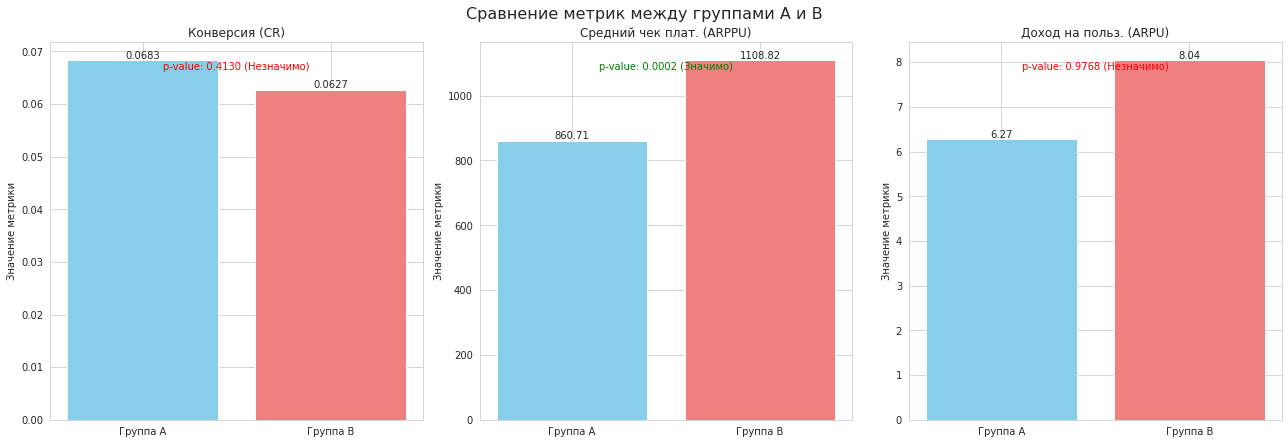


Графики построены.


In [51]:
plot_metrics(metrics)